In [2]:
#%run -i '../../scripts/utility_readblt.py' 'etau'

In [1]:
from utility_common import *
from utility_plotter import *
import ROOT
from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline
#%qtconsole --style monokai
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

Welcome to JupyROOT 6.13/02


# 1. Read data and MC as dataframe

In [2]:
selection  = "etau"
pickledir  = "/mnt/data/zchen/Analysis/pickle/{}/".format(selection)

In [3]:
def prepare_df_list(nbjetcut):
    cuts = GetSelectionCut(selection) + "& (nBJets{})".format(nbjetcut)

    Data = LoadDataframe(pickledir + "data2016").query(cuts)
    MCzz = LoadDataframe(pickledir + "mcdiboson").query(cuts)
    MCdy = LoadDataframe(pickledir + "mcdy").query(cuts)
    MCt  = LoadDataframe(pickledir + "mct").query(cuts)
    MCtt = LoadDataframe(pickledir + "mctt").query(cuts)

    # signal mc is tt+tW
    MCsg = pd.concat([MCt,MCtt],ignore_index=True)

    MCsgf = MCsg.query('genCategory in [17,21] ') # semilep and had
    MCsg0 = MCsg.query('genCategory in [1,2,3, 4,5,6,7,8,9, 13,14,15]') #other lep
    MCsg1 = MCsg.query('genCategory in [16]') #eh
    MCsg2 = MCsg.query('genCategory in [18,19,20]') #tauh
    MCsg3 = MCsg.query('genCategory in [10,11,12]') #etau

    return [MCzz,MCdy,MCsgf,MCsg0,MCsg1,MCsg2,MCsg3,Data],MCt,MCtt

# 2. Plot kinematics

In [4]:
pp = pd.read_csv("plotparameters.csv")
label_list = ["Diboson","V+Jets",r'$tt/tW \rightarrow l + h$ (other)',
              r'$tt/tW \rightarrow l + l$ (other) ',
              r'$tt/tW \rightarrow \mu + h$', 
              r'$tt/tW \rightarrow \tau + h$',
              r'$tt/tW \rightarrow \mu + \tau$',
              'data']
color_list = ["#a32020","#e0301e","#eb8c00","gold","#49feec","deepskyblue","mediumpurple","k"]

In [10]:
for nbjetcut in ["==1",">1",">=1"]:
    df_list,_,__ = prepare_df_list(nbjetcut)
    plotoutdir = GetPlotDir(selection, nbjetcut)
    for index, row in pp.iterrows():
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        
        plotter = SelectionPlotter(v,a,b,step,df_list)
        plotter.settingPlot(xl,label_list,color_list)
        plotter.makePlot(plotoutdir)

        print("making plots nbjet{0}: {1}/{2}".format(nbjetcut,index,len(pp)))
        clear_output(wait=True)
        plt.close()
        
print('finish all making plots')

finish all making plots


# 3. Counting

In [5]:
nbjetcut = ">=1"
df_list,MCt,MCtt = prepare_df_list(nbjetcut)
ctr = SelectionCounter()

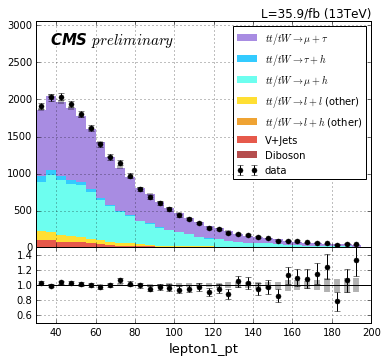

In [6]:
plt.rc("figure",facecolor="w",figsize=(6,4))

v,a,b,step,xl = "lepton1_pt",30,200,5,"lepton1_pt"
plotter = SelectionPlotter(v,a,b,step,df_list,adjust=[1,1,1,1,1,1,1,1])
plotter.settingPlot(xl,label_list,color_list,plotWithoutXsErr=False)
plotter.makePlot()

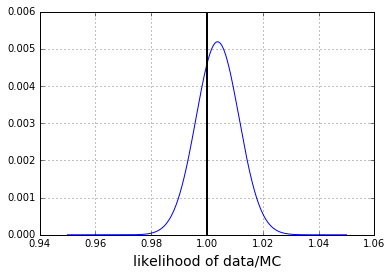

In [7]:
ratio = plotter.hdata/plotter.mctot
err   = sqrt((plotter.hdata**0.5/plotter.mctot)**2 + (plotter.mcerr/plotter.mctot)**2)

x = np.linspace(0.95,1.05,1000)
l = np.ones_like(x)
for i in range(len(ratio)):
    norm = (1/sqrt(2*np.pi*err[i]**2))
    l *= norm*np.exp(-(x-ratio[i])**2/(2*err[i]**2))
    #nll = nll+(x-ratio[i])**2/(2*err[i]**2)
l = l/np.sum(l)

plt.plot(x,l)
plt.xlabel("likelihood of data/MC",fontsize=14)
plt.axvline(1,c="k",lw=2)
plt.grid()

np.save("dataMCRatio/etau_095to105", l)

In [22]:
print("(nBJets{})".format(nbjetcut))

print("MCtt: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=False)) )
print("MCtt width: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=True)) )

print("MCt : {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=False)) )
print("MCt width: {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=True)) )

(nBJets>1)
MCtt: [158, 0, 60, 1, 0, 0, 805, 0, 7, 33, 24, 15504, 1, 0, 0, 9210, 1, 480, 0, 11, 3]
MCtt width: [130.57697759844362, 0, 50.05026440686545, 0.8895741188526154, 0, 0, 684.7226031344867, 0, 6.2043808948993675, 27.422577847503124, 21.551411371231076, 13522.534619865999, 0.9373763430118561, 0, 0, 8049.773023235248, 0.36285650372505185, 417.15499688389707, 0, 8.934245167151092, 2.72306426346302]
MCt : [0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 70, 0, 0, 0, 42, 0, 1, 0, 0, 0]
MCt width: [0, 0, 0, 0.45709801465272903, 0, 0, 2.788743698000908, 0, 0, 0, 0, 60.995141455680134, 0, 0, 0, 36.88875360801816, 0, 0.9714282989501952, 0, 0, 0]


In [23]:
ctr.countSlt_Scaled(df_list)

data:4532.0
TotalMC:4600.326357177784
------ MC break down ------
[2.68369881e+00 5.79998993e+01 5.93259084e-01 1.72123739e+02
 1.59544842e+03 8.31785508e+01 2.68829879e+03]


In [24]:
for thisdf in [df_list[0],df_list[1], MCt, MCtt, df_list[-1]]:
    n = np.sum(thisdf.eventWeight)
    nerr = np.sum(thisdf.eventWeight**2)**0.5
    print('{:.2f},{:.2f}'.format(n,nerr))

2.68,1.03
58.00,7.87
132.60,12.61
4407.04,27.91
4532.00,67.32


In [14]:
# print Generator information
f = ROOT.TFile("../../data/root/2016MC.root")
print("MCtt : {}".format(ctr.countGen_ByTauDecay(f,'ttbar_inclusive')) )
temp = np.array(ctr.countGen_ByTauDecay(f,'t_tw'))
temp+= np.array(ctr.countGen_ByTauDecay(f,'tbar_tw'))
print("MCt  : {}".format(list(temp)) )

MCtt : [1811409.0, 1811532.0, 3620281.0, 57057.0, 54227.0, 111125.0, 418126.0, 418126.0, 763147.0, 642646.0, 626108.0, 2350887.0, 643368.0, 627277.0, 2353727.0, 22670017.0, 22653517.0, 4016590.0, 3923504.0, 14718933.0, 70930278.0]
MCt  : [23105.0, 23040.0, 46342.0, 694.0, 717.0, 1420.0, 5260.0, 5260.0, 9727.0, 8199.0, 8029.0, 30054.0, 8163.0, 8006.0, 29970.0, 290101.0, 289467.0, 50864.0, 50050.0, 187515.0, 904067.0]


In [7]:
f = ROOT.TFile("../../data/root/2016MC2_reverseISO.root")

In [6]:
t = f.Get('TotalEvents_z1jets_m-50')

In [28]:
t.GetBinContent(1)

62626049.0

In [29]:
t.GetBinContent(11)

62063999.64373939